In [261]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [25]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
my_tables = Base.classes.keys()

['measurement', 'station']

In [30]:
Inspector = inspect(engine)

In [36]:
for t in my_tables:
    print(t)
    my_cols = Inspector.get_columns(t)
    for c in my_cols:
        print(f"{c['name']}, {c['type']}")
    print("")

measurement
id, INTEGER
station, TEXT
date, TEXT
prcp, FLOAT
tobs, FLOAT

station
id, INTEGER
station, TEXT
name, TEXT
latitude, FLOAT
longitude, FLOAT
elevation, FLOAT



In [37]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [38]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [206]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

#find max date to use in filter -- last date in db
max_date = session.query(func.max(Measurement.date)).scalar()

#build query to parse the date
yr_col = func.substr(Measurement.date, 0,5)
mo_col = func.substr(Measurement.date, 6, 2)
day_col = func.substr(Measurement.date, 9,2)

#return the date parts
max_date_pts = session.query(yr_col, mo_col, day_col).filter(Measurement.date == max_date).first()

#update the date to show one year previous
new_date = str(int(max_date_pts[0]) -1) + '-' + max_date_pts[1] + '-' + max_date_pts[2]

print(f'Dataframe of precipitation for dates after {new_date}.')

# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

import pandas as pd
conn = engine.connect()
prcp_df = pd.read_sql(f"select date, prcp from measurement where date >= '{new_date}' order by date", conn)
prcp_df.set_index('date')


Dataframe of precipitation for dates after 2016-08-23.


,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


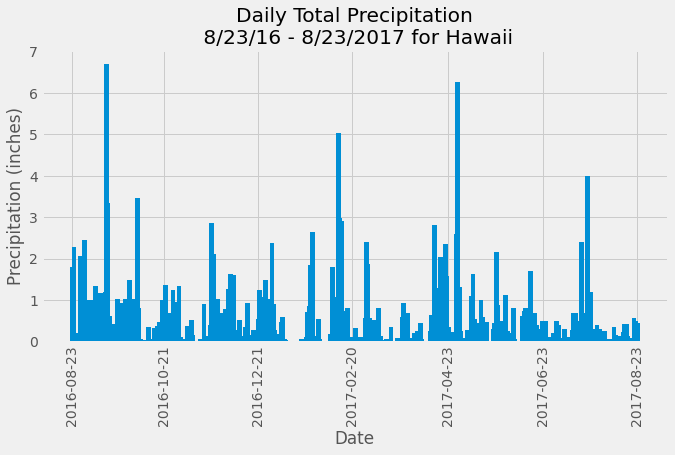

In [296]:
# Use Pandas Plotting with Matplotlib to plot the data



#plot data
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 5))

# Add x-axis and y-axis
ax.bar(prcp_df['date'],
       prcp_df['prcp'],
       width=3.0)

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Precipitation (inches)",
       title="Daily Total Precipitation\n 8/23/16 - 8/23/2017 for Hawaii")


ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=90)
plt.show()




In [248]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [311]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()

9

In [325]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [323]:
#verifying count
engine.execute('select count(*) from Measurement').scalar()

19550

In [341]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active_station = session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()[0]

max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == active_station).scalar()
min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == active_station).scalar()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == active_station).scalar()

print(f"At the most active station, station {active_station}, the lowest temperature recorded was {min_temp}. The highest temperature recorded was {max_temp}, and average temperature was {np.round(avg_temp, 0)}")


At the most active station, station USC00519281, the lowest temperature recorded was 54.0. The highest temperature recorded was 85.0, and average temperature was 72.0


In [351]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_df = pd.read_sql(f"select * from measurement where station == '{active_station}'", conn)
active_station_df

,id,station,date,prcp,tobs
0,12188,USC00519281,2010-01-01,0.15,70.0
1,12189,USC00519281,2010-01-02,0.00,62.0
2,12190,USC00519281,2010-01-03,0.00,74.0
3,12191,USC00519281,2010-01-04,0.00,75.0
4,12192,USC00519281,2010-01-05,0.00,74.0
...,...,...,...,...,...
2767,14955,USC00519281,2017-08-14,0.00,77.0
2768,14956,USC00519281,2017-08-15,0.32,77.0
2769,14957,USC00519281,2017-08-16,0.12,76.0
2770,14958,USC00519281,2017-08-17,0.01,76.0


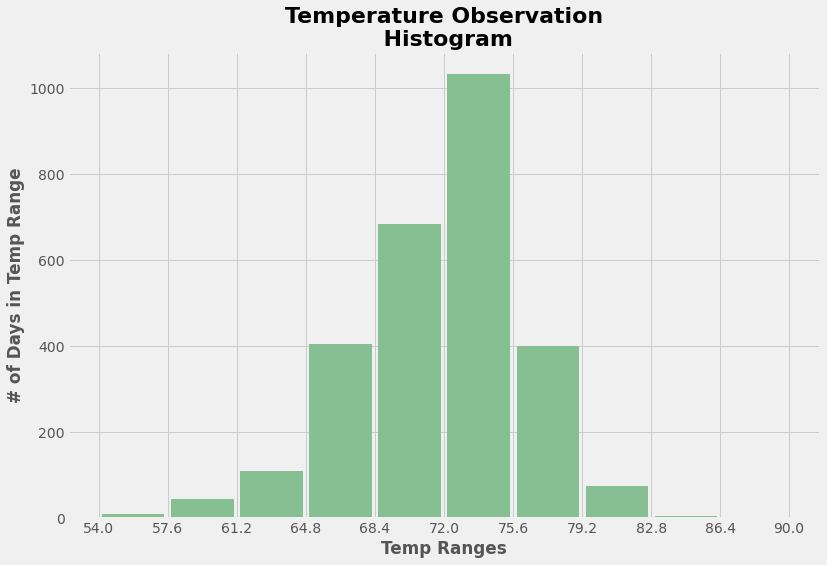

In [353]:
#and plot the results as a histogram
min_temp = min(active_station_df['tobs'])
max_temp = np.ceil(max(active_station_df['tobs']) / 10) * 10
temp_rge = max_temp - min_temp
bins_x = np.arange(min_temp,max_temp+1, temp_rge/10)


fig, ax = plt.subplots(figsize=(12,8))

ax.hist(active_station_df  ['tobs'], bins=bins_x, color='#86bf91', zorder=2, rwidth=0.9)
ax.set_title('Temperature Observation\n Histogram', weight = 'bold', fontsize=22)
ax.set_xlabel('Temp Ranges', weight = 'bold')
ax.set_ylabel('# of Days in Temp Range', weight = 'bold')
ax.set_xticks(bins_x)
plt.show()

## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [23]:
# Plot the daily normals as an area plot with `stacked=False`
